In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

In [2]:
import re
from scipy.stats import entropy

df = pd.read_csv("../contrastes/provincias.csv", quotechar="\"", decimal=",")
df = df.set_index("palabra")

fnorm_vars = [c for c in df.columns if re.match(r'fnorm_.*', c)]
cant_palabras = [c for c in df.columns if re.match(r'.*Palabras$', c)]
cant_personas = [c for c in df.columns if re.match(r'.*Personas$', c)]

In [3]:
from iv_helpers import simulated_shuffled_entropy_multinomial

fn = lambda ws: simulated_shuffled_entropy_multinomial(ws, len(cant_palabras))

df["entropy_palabras"] = df[cant_palabras].apply(entropy, axis=1, raw=True)
df["entropy_personas"] = df[cant_personas].apply(entropy, axis=1, raw=True)
df["shuffled_entropy_personas"] = df.cantUsuariosTotal.apply(fn)
df["shuffled_entropy_palabras"] = df.cantPalabra.apply(fn)

In [4]:
print df.cantUsuariosTotal.min()
print df.cantPalabra.min()

6
41


In [5]:
cantPalabrasTotales = sum(df.cantPalabra)
df['fnormArgentina'] = df['cantPalabra']/cantPalabrasTotales

Si le aplico el logaritmo a la cantidad de la Palabra, ya no tiene tanta importancia la cantidad y por lo tanto, las palabras palabras comunes como **que**, **y**,**el**,etc. dejan de tener tanto valor de información

In [6]:
import math
df['normCantPalabras']=(df.cantPalabra.apply(math.log,args=(2,))-df.cantPalabra.apply(math.log,args=(2,)).min())/(df.cantPalabra.apply(math.log,args=(2,)).max()-df.cantPalabra.apply(math.log,args=(2,)).min())
df['normCantPersonas']=(df.cantUsuariosTotal.apply(math.log,args=(2,))-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())/(df.cantUsuariosTotal.apply(math.log,args=(2,)).max()-df.cantUsuariosTotal.apply(math.log,args=(2,)).min())
# df['normCantPalabras']=(df.cantPalabra-df.cantPalabra.mean())/(df.cantPalabra.std())
# df['normCantPersonas']=(df.cantUsuariosTotal-df.cantUsuariosTotal.mean())/(df.cantUsuariosTotal.std())

In [7]:
from iv_helpers import lugares
places = lugares()
print len(places)
df['esLugar'] = np.where(df.index.str.decode(encoding='utf-8').isin(places),'lugar','ok')

3006


### Normalizo el valor de la cantidad de ocurrencias de una palabra y de usuarios que la utilizan.

$$ norm_{CantPalabras} = \frac{log_2(\#Palabra)- min(log_2(\#Palabra))}{max(log_2(\#Palabra)) - min(log_2(\#Palabra))}$$

$$norm_{CantPersonas} = \frac{log_2(\#Usuarios)- min(log_2(\#Usuarios))}{max(log_2(\#Usuarios)) - min(log_2(\#Usuarios))}$$

De esta forma, estos dos valores están en el rango 0-1

La métrica llamada $InformationValue_{PersonasPalabras}$

$$InformationValue_{PersonasPalabras} =  norm_{CantPalabras} * norm_{CantPersonas} * (\widehat{H}_{personas} - H_{personas}) * (\widehat{H}_{palabras} - H_{palabras})$$

donde $\widehat{H}$ es la entropía con las cantidades distribuidas uniformemente y H es la entropía común

In [8]:
import math

df["information_value_palabras"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas"] = (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas)
# df["information_value_personas_palabras"] = (df.cantUsuariosTotal.apply(math.log,args=(2,))) * (df.cantPalabra.apply(math.log,args=(2,))) * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
# df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
df["information_value_personas_palabras"] = df.normCantPalabras * df.normCantPersonas * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)
# df["information_value_personas_palabras"] = df.cantPalabra * df.cantUsuariosTotal * (df.shuffled_entropy_personas - df.entropy_personas) * (df.shuffled_entropy_palabras - df.entropy_palabras)

#df["information_value_FnormMax"] = (df.FnormMax) * (df.shuffled_entropy - df.entropy)

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
df['rankPalabras'] = df['information_value_palabras'].rank(ascending=False).astype('int64')
df['rankPersonas'] = df['information_value_personas'].rank(ascending=False).astype('int64')
df['rankPalabras_Personas'] = df['information_value_personas_palabras'].rank(ascending=False).astype('int64')


palabrasPersonas = [c for c in df.columns if re.match(r'.*PalabrasPersonas', c)]
# df = df.set_index('palabra')
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
df.iloc[:1000][['fnormArgentina','cantPalabra','esLugar','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','normCantPersonas','normCantPalabras','shuffled_entropy_personas','entropy_personas']]

,fnormArgentina,cantPalabra,esLugar,cantUsuariosTotal,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas,normCantPersonas,normCantPalabras,shuffled_entropy_personas,entropy_personas
palabra,,,,,,,,,,,,
chivilcoy,2.161422e-05,4074,lugar,469,buenosaires,4,3,1,0.532714,0.379500,3.103855,0.558161
oberá,2.292996e-05,4322,lugar,378,misiones,3,4,2,0.506352,0.384377,3.093400,0.569656
ushuaia,7.940069e-05,14966,lugar,1006,tierradelfuego,1,48,3,0.625981,0.486874,3.129190,1.453279
ush,1.133765e-05,2137,ok,465,tierradelfuego,11,5,4,0.531668,0.326256,3.112111,0.362702
obera,1.117318e-05,2106,lugar,410,misiones,17,10,5,0.516283,0.325050,3.112268,0.543877
breñas,1.374100e-05,2590,lugar,170,chaco,6,2,6,0.408690,0.342121,3.064233,0.232404
viedma,3.493079e-05,6584,lugar,666,rionegro,7,52,7,0.575573,0.419112,3.112980,1.294115
bragado,1.488166e-05,2805,lugar,294,buenosaires,9,11,8,0.475637,0.348702,3.092879,0.619135
logroño,1.375161e-05,2592,lugar,132,larioja,5,1,9,0.377771,0.342184,3.031733,0.089018


## Hago un dataframe con las palabras candidatas, cada una con las cantidades de ocurrencias por provincia de forma ordenada

In [9]:
cant = [c for c in df.columns if re.match(r'.*Palabras$', c) and (not re.match(r'.*norm', c) ) and (not re.match(r'.*rank', c) )]

dfCant = df[cant]
# Palabras candidatas según la AAL
palabras = ["quedarla","mitaí","angá","yungas","mensajeras","yarco","yarca",
"malpegar","malpegue","malpegada","tareferos","hartante","guaracha","esar","ñeri",
"piadina","chombi","achilata","pollerear","juntadera","pachata","chamigo","chamiga",
"chaque","pichar","tortita","guaso","guasa","comparsero","comparsera","sina","lape","veme","porronear",
"fajita","jia","jía","asada","asar","manso","cora","cumpa","pingo","charro","pinchila","oyo","ura","yuto",
"yagua","cantobar","cha","bombolo","bombola","yafu","jal","gatera","atina",
"guampudo","guampuda","mamila","chui","tico"]


In [10]:
dfC = df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=False)[cant]

In [11]:
sort_xs = dfC.apply(np.sort, axis=1)
sort_index = dfC.apply(np.argsort, axis=1)
sort_xs.columns = range(23)
sort_index.columns = range(23)
cols = sort_xs.columns.tolist()
cols = cols[::-1]
sort_xs = sort_xs[cols]
sort_index = sort_index[cols]
sort_xs.columns= range(23)
sort_index.columns = range(23)

In [12]:
percent = sort_xs.div(sort_xs.sum(axis=1), axis='index')
percent.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
palabra,,,,,,,,,,,,,,,,,,,,,
chivilcoy,0.979872,0.003682,0.003436,0.002209,0.001718,0.001227,0.000982,0.000982,0.000736,0.000736,...,0.000736,0.000491,0.000245,0.000245,0.000245,0.000245,0.000000,0.000000,0.000000,0.000000
oberá,0.981953,0.007867,0.003702,0.001157,0.000925,0.000925,0.000694,0.000463,0.000463,0.000463,...,0.000231,0.000231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ushuaia,0.962649,0.006749,0.004410,0.003140,0.002339,0.002205,0.002071,0.001938,0.001871,0.001670,...,0.001270,0.000935,0.000802,0.000735,0.000535,0.000535,0.000535,0.000535,0.000535,0.000267
ush,0.981750,0.006551,0.001404,0.001404,0.000936,0.000936,0.000936,0.000936,0.000936,0.000468,...,0.000468,0.000468,0.000468,0.000468,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000
obera,0.962013,0.014245,0.005223,0.002374,0.002374,0.002374,0.001899,0.001899,0.001425,0.000950,...,0.000950,0.000475,0.000475,0.000475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


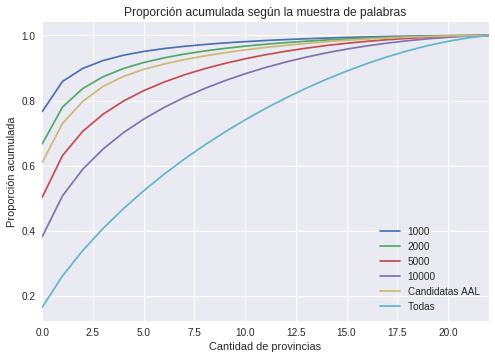

In [13]:
dfAcum = pd.DataFrame()
dfAcum['1000'] = percent.iloc[:1000].cumsum(axis=1).mean()
dfAcum['2000'] = percent.iloc[:2000].cumsum(axis=1).mean()
dfAcum['5000'] = percent.iloc[:5000].cumsum(axis=1).mean()
dfAcum['10000'] = percent.iloc[:10000].cumsum(axis=1).mean()
dfAcum['Candidatas AAL'] = percent.loc[palabras].cumsum(axis=1).mean()
dfAcum['Todas'] = percent.cumsum(axis=1).mean()
ax = dfAcum.plot(kind='line')

ax.set_xlabel(u"Cantidad de provincias")
ax.set_ylabel(u"Proporción acumulada")
ax.set_title(u'Proporción acumulada según la muestra de palabras')
ax2= ax.get_figure()
ax2.savefig("PropAcum.png",dpi=300)

# Vemos como se distribuye la suma acumulada de proporciones de las palabras

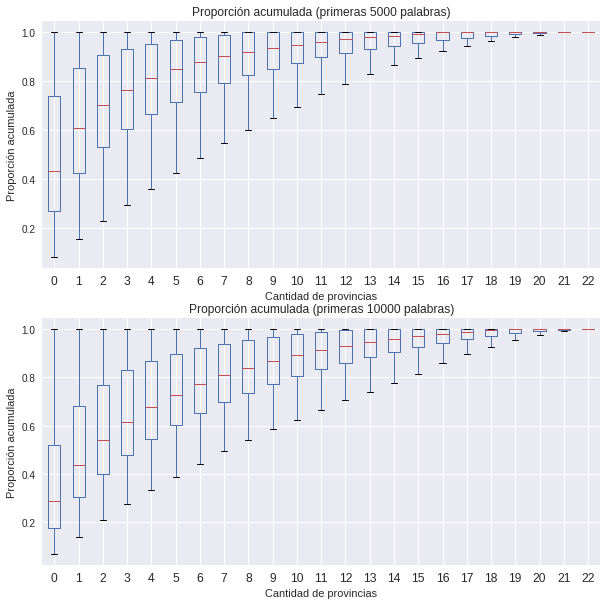

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(10,10))
ax = percent.iloc[:5000].cumsum(axis=1).boxplot(return_type='axes',ax=axes[0])
ax2 = percent.iloc[:10000].cumsum(axis=1).boxplot(return_type='axes',ax=axes[1])
# fig.subplots_adjust(hspace=.8)

ax.set_xlabel(u"Cantidad de provincias")
ax.set_ylabel(u"Proporción acumulada")
ax.set_title(u'Proporción acumulada (primeras 5000 palabras)')

ax2.set_xlabel(u"Cantidad de provincias")
ax2.set_ylabel(u"Proporción acumulada")
ax2.set_title(u'Proporción acumulada (primeras 10000 palabras)')
fig.savefig("PropAcum5000.png",dpi=300)

In [15]:
regiones = pd.DataFrame()
regiones = percent.cumsum(axis=1)
regiones
# regiones["thresh80"] =
def calc(row,thresh):
    for i in range(len(row)):
        if row[i]> thresh:
            return i+1
    
for thresh in np.arange(0.7,1,0.05):
    print "La media de provincias con threshold igual a " + str(thresh) + ": " + str(regiones[:5000].apply(calc,args=(thresh,),axis=1).mean())


La media de provincias con threshold igual a 0.7: 4.0306
La media de provincias con threshold igual a 0.75: 4.7362
La media de provincias con threshold igual a 0.8: 5.6028
La media de provincias con threshold igual a 0.85: 6.7096
La media de provincias con threshold igual a 0.9: 8.2522
La media de provincias con threshold igual a 0.95: 10.6228
La media de provincias con threshold igual a 1.0: 20.1801801802


### Me fijo la región que supera el úmbral por cada palabra

In [16]:
provincias = [x.replace("Palabras","") for x in cant]
def provs(row,thresh):
    for i in range(len(row)):
        if row[i]> thresh:
            cant = sort_index.loc[row.name].iloc[:i+1].tolist()
#             print cant
            return [provincias[x] for x in cant]



print regiones[:5000].apply(provs,args=(0.8,),axis=1)
# print regiones[:5000].apply(provs,args=(0.75,),axis=1).apply(len).mean()
# print regiones[:5000].apply(provs,args=(0.70,),axis=1).apply(len).mean()
# print regiones[:5000].apply(provs,args=(0.90,),axis=1).apply(len).mean()
# print regiones[:5000].apply(provs,args=(0.60,),axis=1).apply(len).mean()



palabra
chivilcoy                                             [buenosaires]
oberá                                                    [misiones]
ushuaia                                            [tierradelfuego]
ush                                                [tierradelfuego]
obera                                                    [misiones]
breñas                                                      [chaco]
viedma                                                   [rionegro]
bragado                                               [buenosaires]
logroño                                                   [larioja]
nqn                                                       [neuquen]
tdf                                                [tierradelfuego]
riojanos                                                  [larioja]
charata                                                     [chaco]
chivil                                                [buenosaires]
cldo                                    

In [17]:
df['regionTest'] = regiones.apply(provs,args=(0.8,),axis=1)

In [18]:
# cantidad de palabras con esa provincia que tiene mucha proporción de ocurrencias
for p in provincias:
    print  p +' '+ str(sum(df['regionTest'].apply(lambda x : p in x)))

buenosaires 41687
catamarca 38866
chaco 35029
chubut 45375
cordoba 52268
corrientes 44187
entrerios 46127
formosa 33496
jujuy 31292
lapampa 45560
larioja 36070
mendoza 48770
misiones 36462
neuquen 45678
rionegro 49776
salta 42648
sanjuan 41640
sanluis 34638
santacruz 37434
santafe 49554
santiago 32465
tierradelfuego 48185
tucuman 49742


In [19]:
df.regionTest.iloc[1]

['misiones']

In [20]:
cols = df.columns.tolist()
cols = [cols[-1]] + cols[:-1] 
    # "commit" the reordering
df = df[cols]

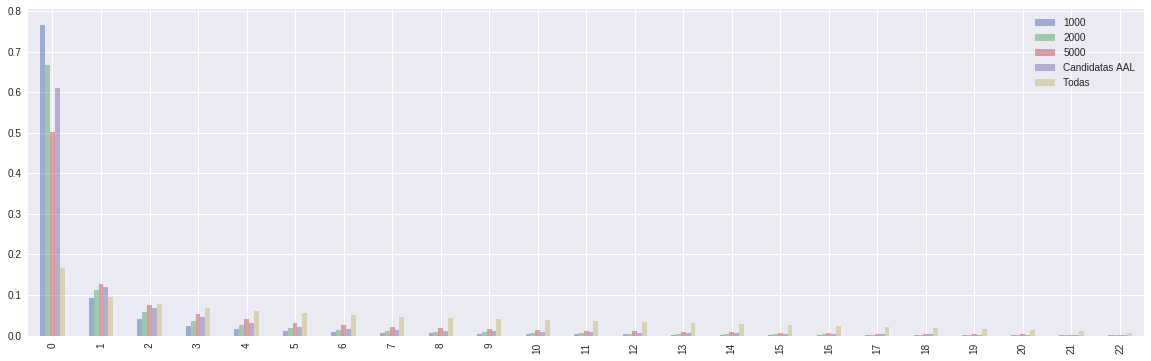

In [21]:
dfp = pd.DataFrame()
dfp['1000'] = percent.iloc[0:1000].mean().T
dfp['2000'] = percent.iloc[0:2000].mean().T
dfp['5000'] = percent.iloc[0:5000].mean().T
dfp['Candidatas AAL'] = percent.loc[palabras].mean().T
dfp['Todas'] = percent.mean().T
dfp.plot(kind='bar',figsize=[20,6],alpha=0.5)

## Hago un dataframe con las palabras candidatas, cada una con las provincias ordenadas según cuantas veces ocurre una palabra en cada una de ellas

In [22]:
df.sort_values(by='information_value_personas_palabras',ascending=False,inplace=True)
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
df.iloc[:7000][['cantPalabra','cantUsuariosTotal','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas','entropy_palabras','entropy_personas']].to_csv('resumido.csv')

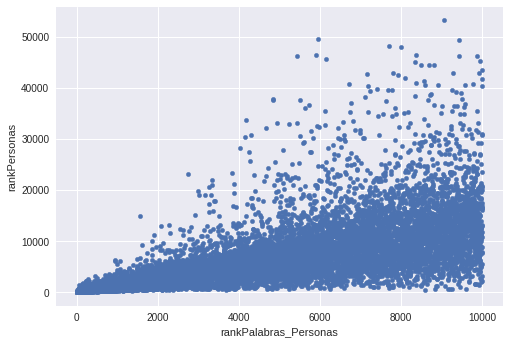

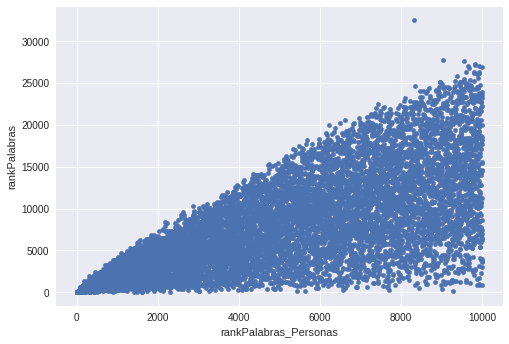

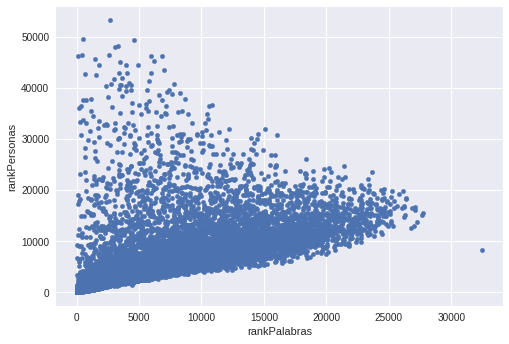

In [23]:
df.iloc[:10000].plot.scatter(x='rankPalabras_Personas',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='rankPalabras_Personas',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='rankPalabras',y='rankPersonas')

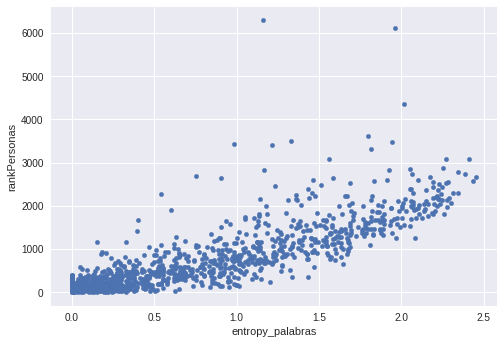

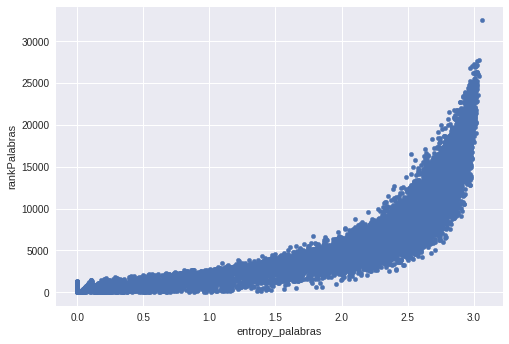

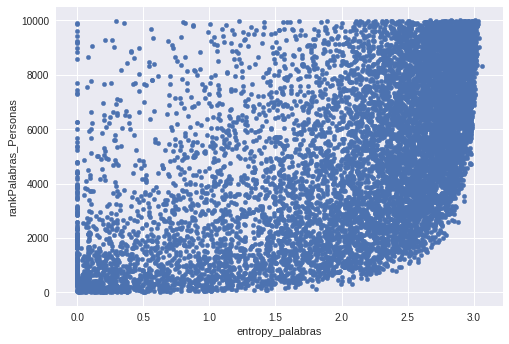

In [24]:
df.iloc[:1000].plot.scatter(x='entropy_palabras',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='entropy_palabras',y='rankPalabras_Personas')

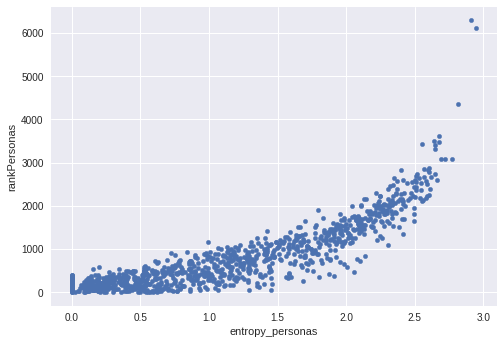

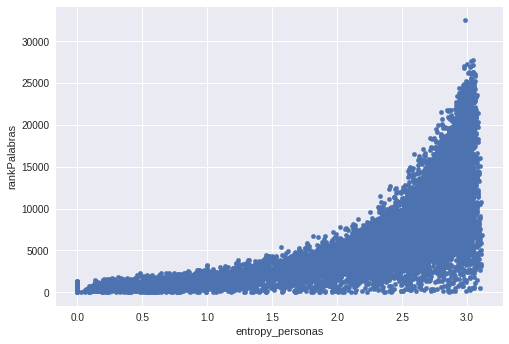

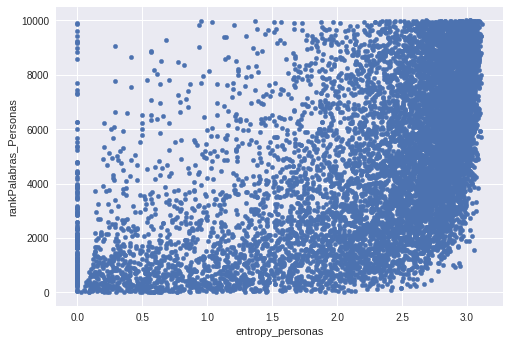

In [25]:
df.iloc[:1000].plot.scatter(x='entropy_personas',y='rankPersonas')
df.iloc[:10000].plot.scatter(x='entropy_personas',y='rankPalabras')
df.iloc[:10000].plot.scatter(x='entropy_personas',y='rankPalabras_Personas')

## Guardo los listados (resumidos, y extendidos) ordenados en base a las dos médidas de información

In [26]:
df.sort_values(by="information_value_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_palabras_resumida.csv')
df.to_csv('ivalue_entropia_palabras.csv')

df.sort_values(by="information_value_personas", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed.to_csv('ivalue_entropia_personas_resumida.csv')
df.to_csv('ivalue_entropia_personas.csv')

df.sort_values(by="information_value_personas_palabras", ascending=False, inplace=True)
resumed = df[df.columns.difference(cant_palabras+fnorm_vars + palabrasPersonas)]
resumed = resumed[['cantPalabra','esLugar','regionTest','cantUsuariosTotal','fnormArgentina','provinciaFnormMax','rankPalabras','rankPersonas','rankPalabras_Personas']]
resumed.to_csv('ivalue_entropia_personas_palabras_resumida.csv')


df.to_csv('ivalue_entropia_personas_palabras.csv')

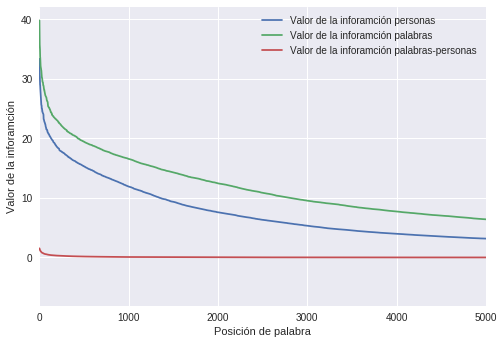

In [54]:
df2 = df.sort_values(by="information_value_personas", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas.plot(xlim=[0,5000])
df2 = df.sort_values(by="information_value_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_palabras.plot(xlim=[0,5000])

df2 = df.sort_values(by="information_value_personas_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas_palabras.plot(xlim=[0,5000])
ax2.legend([u'Valor de la inforamción personas',u'Valor de la inforamción palabras',u'Valor de la inforamción palabras-personas'])


ax2.set_xlabel(u'Posición de palabra')
ax2.set_ylabel(u'Valor de la inforamción')

ax= ax2.get_figure()
ax.savefig("ivalues.svg",dpi=300)

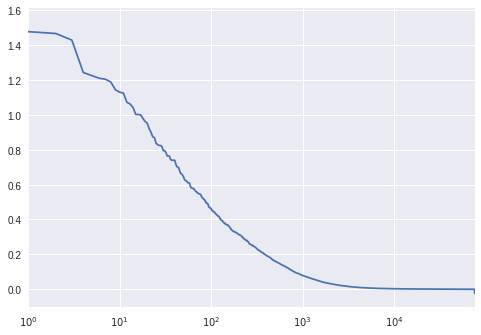

In [53]:
df2 = df.sort_values(by="information_value_personas_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas_palabras.plot(logx=True)

ax= ax2.get_figure()
ax.savefig("ivaluesLog.svg",dpi=300)

In [30]:
df.information_value_personas_palabras.describe()

count    75878.000000
mean         0.004874
std          0.036176
min         -0.024401
25%          0.000023
50%          0.000169
75%          0.000793
max          1.534896
Name: information_value_personas_palabras, dtype: float64

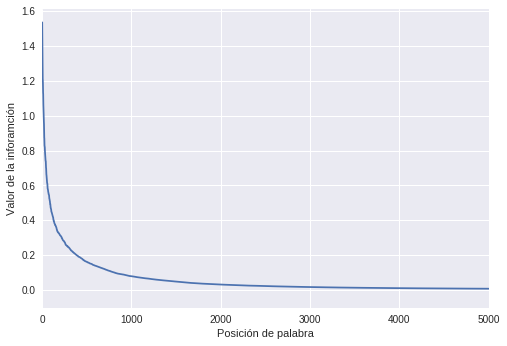

In [31]:
df2 = df.sort_values(by="information_value_personas_palabras", ascending=False)
df2 = df2.reset_index()
ax2 = df2.information_value_personas_palabras.plot(xlim=[0,5000])


ax2.set_xlabel(u'Posición de palabra')
ax2.set_ylabel(u'Valor de la inforamción')

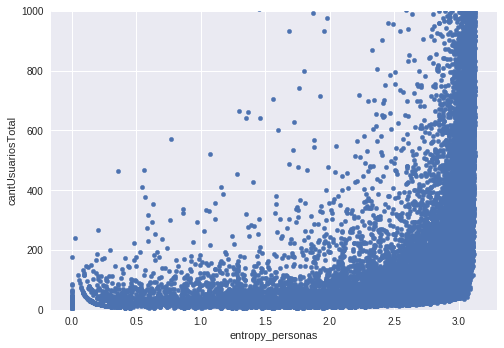

In [32]:
df.plot.scatter(x="entropy_personas", y="cantUsuariosTotal", ylim=[0, 1000])

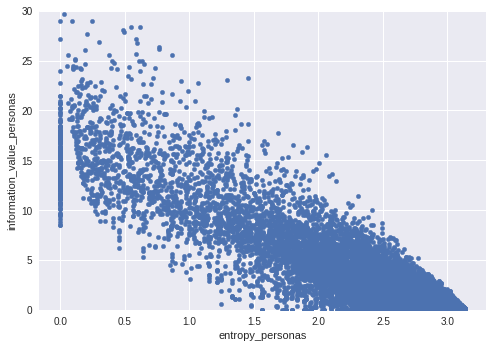

In [33]:
df.plot.scatter(x="entropy_personas", y="information_value_personas", ylim=[0, 30])

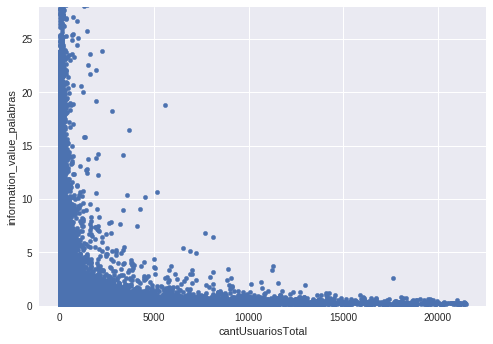

In [34]:
df.plot.scatter(x="cantUsuariosTotal", y="information_value_palabras", ylim=[0, 28])

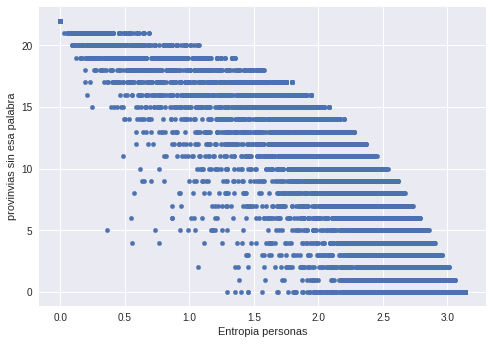

In [35]:
plt.figure(1)
df.plot.scatter(x="entropy_personas", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia personas")
plt.ylabel("provinvias sin esa palabra")


plt.show()


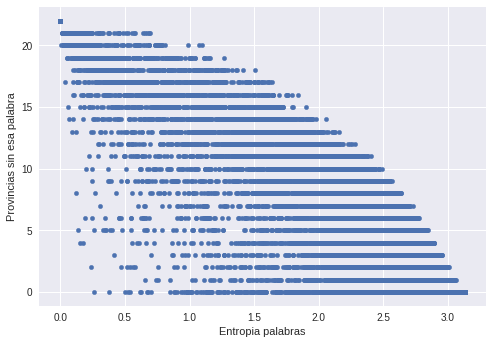

In [36]:
plt.figure(2)
df.plot.scatter(x="entropy_palabras", y="provinciaSinEsaPalabra")
plt.xlabel("Entropia palabras")
plt.ylabel("Provincias sin esa palabra")

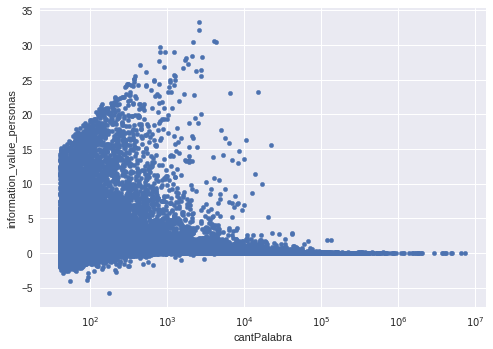

In [37]:
df.plot.scatter(y="information_value_personas", x="cantPalabra", logx=True)

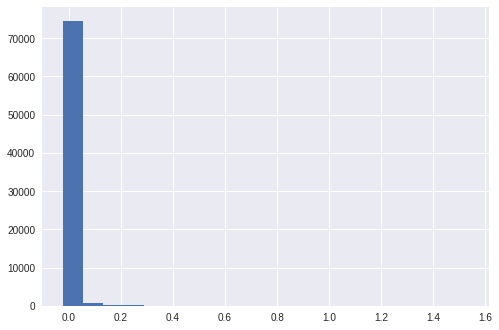

In [57]:
df.information_value_personas_palabras.hist(bins=20)

In [39]:
resumed[df.information_value_personas < 0].iloc[:100]

/home/dami/tesis/venv/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,cantPalabra,esLugar,regionTest,cantUsuariosTotal,fnormArgentina,provinciaFnormMax,rankPalabras,rankPersonas,rankPalabras_Personas
palabra,,,,,,,,,
fueraa,91,ok,"[buenosaires, catamarca, chaco, sanluis, lapam...",83,4.827919e-07,chaco,75812,75349,22675
reemplazarte,68,ok,"[catamarca, tucuman, rionegro, formosa, mision...",67,3.607676e-07,catamarca,75762,75571,26881
madraza,59,ok,"[jujuy, santafe, corrientes, salta, larioja, t...",53,3.130189e-07,jujuy,75818,75751,26971
traficar,60,ok,"[buenosaires, neuquen, cordoba, catamarca, ent...",57,3.183243e-07,buenosaires,75843,75579,28127
silencia,65,ok,"[sanluis, tierradelfuego, chaco, sanjuan, tucu...",61,3.448513e-07,sanluis,75789,75508,28287
secuestrador,63,ok,"[sanjuan, jujuy, tucuman, chaco, entrerios, sa...",62,3.342405e-07,jujuy,75700,75619,29407
nefastas,68,ok,"[tucuman, larioja, tierradelfuego, misiones, c...",59,3.607676e-07,larioja,75505,75643,30588
indocumentados,64,ok,"[chubut, catamarca, chaco, corrientes, salta, ...",60,3.395459e-07,chubut,75624,75578,30983
perduran,87,ok,"[jujuy, sanjuan, formosa, corrientes, neuquen,...",84,4.615702e-07,jujuy,75448,74964,31129


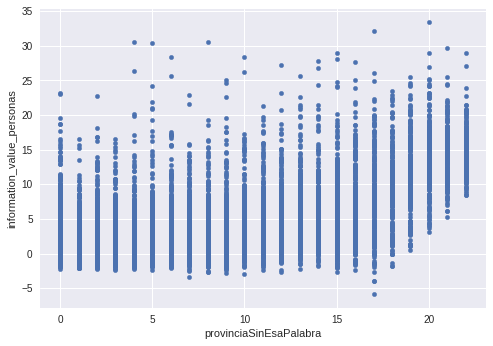

In [40]:
df.plot.scatter(x="provinciaSinEsaPalabra", y="information_value_personas")

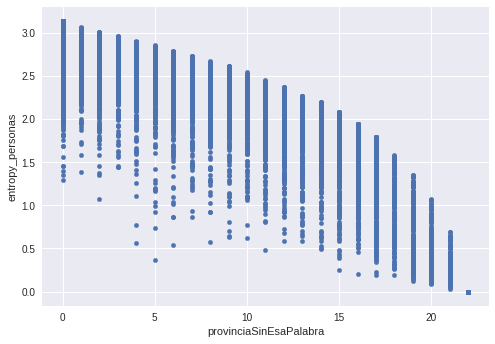

In [41]:
df.plot.scatter(x="provinciaSinEsaPalabra", y="entropy_personas")

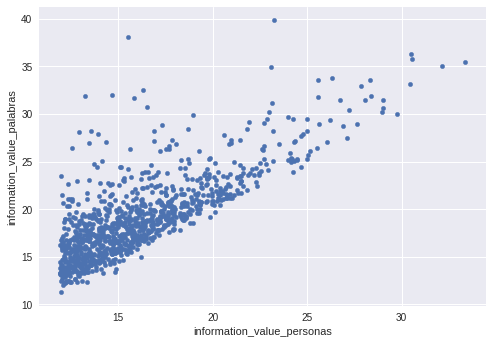

In [42]:
ax = df.iloc[:1000].plot(kind='scatter',x='information_value_personas',y='information_value_palabras')
plt.show()

In [43]:
df[df.provinciaSinEsaPalabra > 17].iloc[:5000][["cantPalabra", "provinciaSinEsaPalabra"]]

,cantPalabra,provinciaSinEsaPalabra
palabra,,
logroño,2592,20
chivil,811,21
sciurano,929,20
ipauss,812,22
vallerga,448,22
plottier,908,20
unju,1282,19
kraka,382,21
afrah,375,20


In [61]:
# df[len(df.regionTest) < 2].iloc[:5000][["cantPalabra", "provinciaSinEsaPalabra"]]
sum(df.regionTest.map(lambda x: 'cordoba' in x and 'santafe' in x))

37045

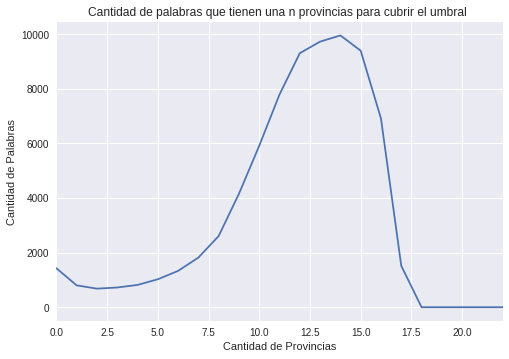

In [106]:
a = []
for i in range(1,24):
    cantProvincias = sum(df.regionTest.map(lambda x: len(x)==i))
    a.append(cantProvincias)
#     print str(i)+ ': ' + str(cantProvincias)
fig = pd.Series(a).plot(title='Cantidad de palabras que tienen una n provincias para cubrir el umbral ')
fig.set_xlabel(xlabel='Cantidad de Provincias')
fig.set_ylabel(ylabel='Cantidad de Palabras')

In [86]:
df.regionTest

palabra
logroño                                                              [larioja]
breñas                                                                 [chaco]
chivilcoy                                                        [buenosaires]
oberá                                                               [misiones]
ush                                                           [tierradelfuego]
chivil                                                           [buenosaires]
blv                                                                  [sanluis]
sciurano                                                      [tierradelfuego]
ipauss                                                        [tierradelfuego]
obera                                                               [misiones]
bragado                                                          [buenosaires]
cldo                                                                 [mendoza]
fueguinos                                   

In [44]:
(df.shuffled_entropy_personas - df.entropy_personas).describe()

count    75878.000000
mean         0.142183
std          0.336801
min         -0.780355
25%          0.013662
50%          0.050522
75%          0.135548
max          3.079813
dtype: float64

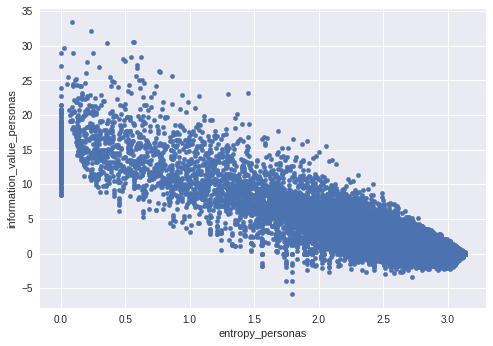

In [45]:
df.plot.scatter(x="entropy_personas", y="information_value_personas")

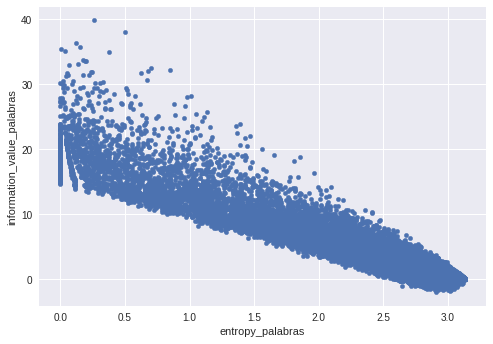

In [46]:
df.plot.scatter(x="entropy_palabras", y="information_value_palabras")

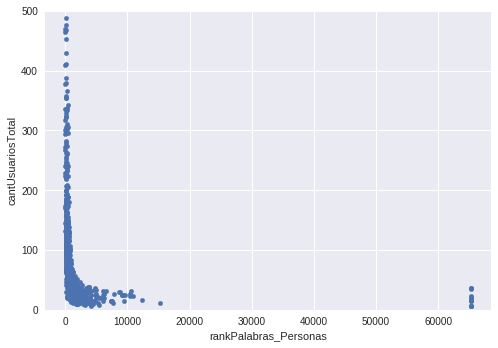

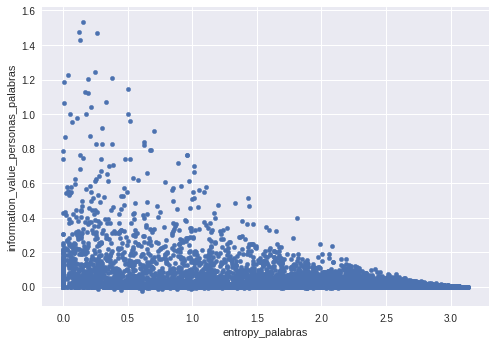

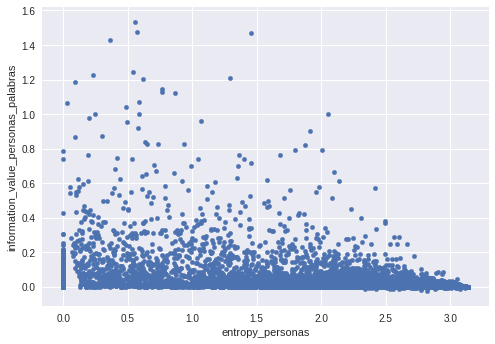

In [47]:
df.iloc[:1000].plot.scatter(x="rankPalabras_Personas", y="cantUsuariosTotal",ylim=[0,500])

df.plot.scatter(x="entropy_palabras", y="information_value_personas_palabras")
df.plot.scatter(x="entropy_personas", y="information_value_personas_palabras")


In [48]:
print 'Hay {0} lugares en las primeras 5000 palabras.'.format(len(df.iloc[:5000][df.iloc[:5000].esLugar == 'lugar']))

Hay 535 lugares en las primeras 5000 palabras.
